[37 微调](https://www.bilibili.com/video/BV1Sb4y1d7CR/?spm_id_from=333.788.recommend_more_video.0)
- 也许是深度学习最重要的部分之一
- <img src="picture\屏幕截图 2022-05-24 005020.png"></a>
- 适合 ImageNet 的复杂模型可能会在自己的数据集上过拟合，另外由于训练样本有限，训练模型的准确性可能无法满足实际要求，解决以上问题有两种解决方案：

    1. 收集更多的数据。数据集越大越好，但是收集和标记数据可能需要大量的时间和金钱。

    2. *应用迁移学习（transfer leanring）*。将从源数据集学到的知识迁移到目标数据集，通常来说希望在大数据集上训练好的模型能够提取到更通用的图像特征，有助于识别边缘、纹理、形状和对象组合，从而帮助提升在自己数据集上的精度，核心思想是假设模型对整个物体识别有一定的基础的情况下，不需要自己提供太大的数据集就能够获得很好的识别精度，这也是人工智能所追求的目标
- <img src="picture\屏幕截图 2022-05-24 010128.png"></a>

- 网络架构



    - 一个神经网络一般可以分为两块，一部分做特征提取，一部分做线性分类

    - 假设将一张图像输入到模型中，可以认为最下面的一部分是在进行特征提取（特征抽取就是将原始像素变成容易线性分割的特征，深度学习的突破性进展就在于特征提取是可以学习的，而不用人工思考如何提供特征）
    - 最后一部分就是一个全连接层和 softmax 来进行分类

- <img src="picture\屏幕截图 2022-05-24 010605.png"></a>


    - 假设在源数据集（一个比较大的数据集）上已经训练好了一个模型，模型中特征提取的部分对源数据集是有效的，那么它对目标数据集也应该是有效的，这样做是优于随机生成提取特征的
    - 最后一部分是不能直接使用的，因为标号发生了改变，所以最后一部分难以进行重用
    - 微调的核心思想是：在一个比较大的源数据集上训练好的模型中用于特征提取的部分，在目标数据集上提取特征时进行重用

- <img src="picture\屏幕截图 2022-05-24 010819.png"></a>
    - pre-train预先训练好的模型，目标数据集则采用相同结构的神经网络
    - 新模型的权重不在采用随机初始化，而是采用pre-train中训练好的权重
    - 当然最后一层因为和pre-train不一样，只能随机初始化

- <img src="picture\屏幕截图 2022-05-24 011228.png"></a>
    - lr和epoch都应该减少了，因为我们已经认为是拿了个很好的模型
    - 人家已经很牛逼了，没必要自己再来

- <img src="picture\屏幕截图 2022-05-24 012111.png"></a>
    - 如果需要进行分类的类别中恰好在源数据中也有对应分类
    - 可以把这部分向量拿过来用（怎么做的的？？？）

- <img src="picture\屏幕截图 2022-05-24 012540.png"></a>
- 神经网络通常学习有层次的特征表示

    - 低层次的特征更加通用（越低层次学习的是一些底层的细节）
    - 高层次的特征则更跟数据集相关（越高层次则更加语义化）
    - 可以认为越到后面和标号的关联度越大，约到前面则越低层，所以底层的特征更加通用，高层的特征和数据的关联度更大
    - 可以固定底部一些层的参数，不参与更新（不做优化，在微调的时候不改变底层类别的权重，因为这些参数不再发生变化，所以模型的复杂度变低了，可以认为是更强的正则的效果）

# 总结



1. 微调的核心思想是薅大公司羊毛，用他们的牛刀（pre-train）来杀鸡(你的模型)

2. 预训练模型质量很重要

3. 微调通常速度更快，精度更高（可以借助在大数据集上所获得的先验知识）

4. 建议尽量从微调开始训练，不要直接从目标数据集上从零开始进行训练

    - 未来从原始数据集上进行训练的会越来越少，主要是学术界或者大公司在很大的数据集上进行重新训练。
    - 对于个人或者实际应用来讲，通常是使用微调
5. 迁移学习将从源数据集中学到的知识“迁移”到目标数据集，微调迁移学习的常见技巧

6. 除输出层外，目标模型从源模型中复制所有模型设计及其参数，并根据目标数据集对这些参数进行微调，但是目标模型的输出层需要从头开始训练

7. 常微调参数使用较小的学习率，而从头开始训练输出层可以使用更大的学习率

In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [2]:
# @save 这是什么
# 注：这是李沐老师的复用代码的一种方法，没别的特殊含义
# 李沐老师的官方解释如下：使用@save后,该部分函数 类会保存进d2l包中,无需重复定义

d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip',
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

- 首先从图像中裁切随机大小和随机长宽比的区域，然后将该区域缩放为$(224 \times 224)$输入图像。 
- 在测试过程中，需要将图像的高度和宽度都缩放到256像素，然后裁剪中央$(224 \times 224)$区域作为输入。 
- 此外，对于RGB（红、绿和蓝）颜色通道，我们分别标准化每个通道。 具体而言，该通道的每个值减去该通道的平均值，然后将结果除以该通道的标准差。

In [3]:
# 使用RGB通道的均值和标准差，以标准化每个通道
# 这个值基本上已经是通用了,按着来就完全ok了
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

- 使用在ImageNet数据集上预训练的ResNet-18作为源模型。 
- 指定pretrained=True以自动下载预训练的模型参数,不然就只会下载模型

In [4]:
# 构建pre-train模型
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/yang/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

预训练的源模型实例包含许多特征层和一个输出层fc。 此划分的主要目的是促进对除输出层以外所有层的模型参数进行微调。 下面给出了源模型的成员变量fc。

In [5]:
# 512类别输出,hotdog数据集是二分类,所以需要进行修改
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

In [6]:
finetune_net = torchvision.models.resnet18(pretrained=True)
# 这里需要修改输出层了
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
# 给也只给替换的输出层进行权重分配
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[-0.0920, -0.0281,  0.0171,  ...,  0.0143,  0.0752, -0.1027],
        [-0.0539, -0.0563,  0.0814,  ...,  0.0517, -0.0789, -0.0602]],
       requires_grad=True)

In [7]:
# 微调模型
# 如果param_group=True，输出层中的模型参数将使用十倍的学习率
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    # 加载数据,和gpu选择,没啥可看的
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    # reduction：在[none, mean, sum]中选，string型。none表示不降维，返回和target相同形状；
    # mean表示对一个batch的损失求均值；sum表示对一个batch的损失求和。
    loss = nn.CrossEntropyLoss(reduction="none")
    #  新定义块
    if param_group:
        # 获取预训练网络每一层的名字和训练参数,除了最后一层,见下面
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        # 定义优化器,这里分层设置了学习率，最后一层的学习率肯定是要大些才行
        trainer = torch.optim.SGD([{'params': params_1x},
        # 最后的FC层使用十倍学习率
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    #   这个函数和之前没什么区别，主要就是加入了多卡训练
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

In [8]:
for name, param in pretrained_net.named_parameters():
    print(name,param.shape)

conv1.weight torch.Size([64, 3, 7, 7])
bn1.weight torch.Size([64])
bn1.bias torch.Size([64])
layer1.0.conv1.weight torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight torch.Size([64])
layer1.0.bn1.bias torch.Size([64])
layer1.0.conv2.weight torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight torch.Size([64])
layer1.0.bn2.bias torch.Size([64])
layer1.1.conv1.weight torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight torch.Size([64])
layer1.1.bn1.bias torch.Size([64])
layer1.1.conv2.weight torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight torch.Size([64])
layer1.1.bn2.bias torch.Size([64])
layer2.0.conv1.weight torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight torch.Size([128])
layer2.0.bn1.bias torch.Size([128])
layer2.0.conv2.weight torch.Size([128, 128, 3, 3])
layer2.0.bn2.weight torch.Size([128])
layer2.0.bn2.bias torch.Size([128])
layer2.0.downsample.0.weight torch.Size([128, 64, 1, 1])
layer2.0.downsample.1.weight torch.Size([128])
layer2.0.downsample.1.bias torch.Size([128])
layer2.1.conv1.weight tor

loss 0.184, train acc 0.931, test acc 0.938
1006.8 examples/sec on [device(type='cuda', index=0)]


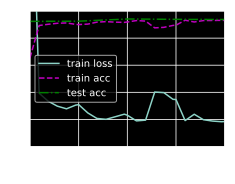

In [9]:
train_fine_tuning(finetune_net,5e-5)

loss 0.356, train acc 0.844, test acc 0.824
1022.7 examples/sec on [device(type='cuda', index=0)]


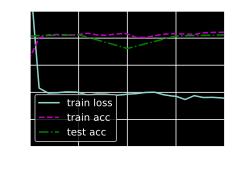

In [10]:
# 全部参数重新训练
# 训练时间更长了，精度下降了
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features,2)
train_fine_tuning(scratch_net,5e-4,param_group=False)